#### Adicionando o caminho do projeto ao path

In [1]:
import os
os.chdir('/Users/edithvidal/Documents/Github/data_science_analysis/')

#### Importando as bibliotecas necessárias para a análise

In [2]:
import helper.graph_helper as graph
import pandas as pd  # type: ignore
import numpy as np # type: ignore
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

#### Lendo os dados da base tratada de 2018 a 2024

In [3]:
df_accidents = pd.read_csv(
    "wrangling/datatran2018_2024_v1.csv",
    parse_dates=["data_inversa", "mes_ano"]
)
df_accidents.info()
df_accidents.reset_index(drop=True, inplace=True)

/var/folders/z1/3syxl8gd5ks431s8c9n9mrs00000gn/T/ipykernel_15310/3262158153.py:1: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_accidents = pd.read_csv(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436643 entries, 0 to 436642
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      436643 non-null  float64       
 1   data_inversa            436643 non-null  datetime64[ns]
 2   tipo_data               436643 non-null  object        
 3   mes_ano                 436643 non-null  datetime64[ns]
 4   dia_semana              436643 non-null  object        
 5   horario                 436643 non-null  object        
 6   fase_dia                436643 non-null  object        
 7   condicao_metereologica  436643 non-null  object        
 8   uf                      436643 non-null  object        
 9   municipio               436643 non-null  object        
 10  br                      436643 non-null  object        
 11  km                      436643 non-null  object        
 12  uso_solo                436643

#### Criando funções auxiliares para gerar os gráficos

In [4]:
def draw_histplot(
    df,
    title="Histograma",
    x_label="",
    y_label="Frequência",
    width=8,
    height=5,
    bins=20,
):
    plt.figure(figsize=(width, height))
    sns.histplot(df, bins=bins)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()


def draw_boxplot(
    df,
    title="Gráfico de caixas",
    x_label="",
    y_label="Frequência",
    width=8,
    height=5,
    multipleLocator=1,
):
    plt.figure(figsize=(width, height))
    sns.boxplot(df)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.gca().yaxis.set_major_locator(
        mticker.MultipleLocator(multipleLocator))
    plt.gca().yaxis.set_major_formatter(
        mticker.StrMethodFormatter("{x:.0f}"))
    plt.show()


def draw_barplot(enable_lineplot, set_yscale, df, x, y, title):
    plt.figure(figsize=(20, 5))
    if set_yscale:
        ax = sns.barplot(data=df, x=x, y=y)
        ax.set_yscale("log")
    else:
        sns.barplot(data=df, x=x, y=y)

    if enable_lineplot:
        sns.lineplot(
            data=df,
            x=x,
            y=y,
            marker="o",
            color="red",
            linewidth=1
        )
        plt.grid(axis="y", linestyle="--", alpha=0.5)

    plt.title(title)
    plt.ylabel("Frequência de acidentes")
    plt.xticks(rotation=45, ha="right")
    plt.margins(x=0)
    plt.show()


def draw_pie(df, labels, title):
    colors = sns.color_palette("pastel")[:len(labels)]

    plt.figure(figsize=(4, 4))
    plt.pie(
        x=df,
        labels=labels,
        autopct="%1.1f%%",
        colors=colors
    )
    plt.title(title)
    plt.show()

#### Criando funções auxiliares para as análises

In [ ]:
def get_months():
    months = {
        1: "Janeiro",
        2: "Fevereiro",
        3: "Março",
        4: "Abril",
        5: "Maio",
        6: "Junho",
        7: "Julho",
        8: "Agosto",
        9: "Setembro",
        10: "Outubro",
        11: "Novembro",
        12: "Dezembro",
    }
    months_sorted = [
        months[1],
        months[2],
        months[3],
        months[4],
        months[5],
        months[6],
        months[7],
        months[8],
        months[9],
        months[10],
        months[11],
        months[12]
    ]

    return months, months_sorted


def get_date_range():
    return pd.date_range(
        start=df_accidents['mes_ano'].min(),
        end=df_accidents['mes_ano'].max(),
        freq='MS'
    )


def sort_by_index(df):
    return df.value_counts().sort_index()


def sort_by_values(df, ascending=False):
    return df.value_counts().sort_values(ascending=ascending)


def group_by_month_year():
    df = sort_by_index(df_accidents["mes_ano"])
    df.index = df.index.strftime("%Y-%m")
    df = df.reindex(
        get_date_range().strftime("%Y-%m"), fill_value=0)

    return df


def group_by_year():
    return sort_by_index(df_accidents["mes_ano"].dt.year)


def group_by_month():
    months, months_sorted = get_months()

    df = sort_by_index(df_accidents["mes_ano"].dt.month)
    df.index = df.index.map(months)
    df.index = pd.Categorical(
        df.index, categories=months_sorted, ordered=True)

    return df


def group_by_hour(df):
    return df[df["horario"].isna() == False]["horario"]


def to_datetime(df):
    return pd.to_datetime(df, format="%H:%M:%S").dt.hour.astype(str).str.zfill(2)

#### Análise da distribuição dos acidentes por mês e ano

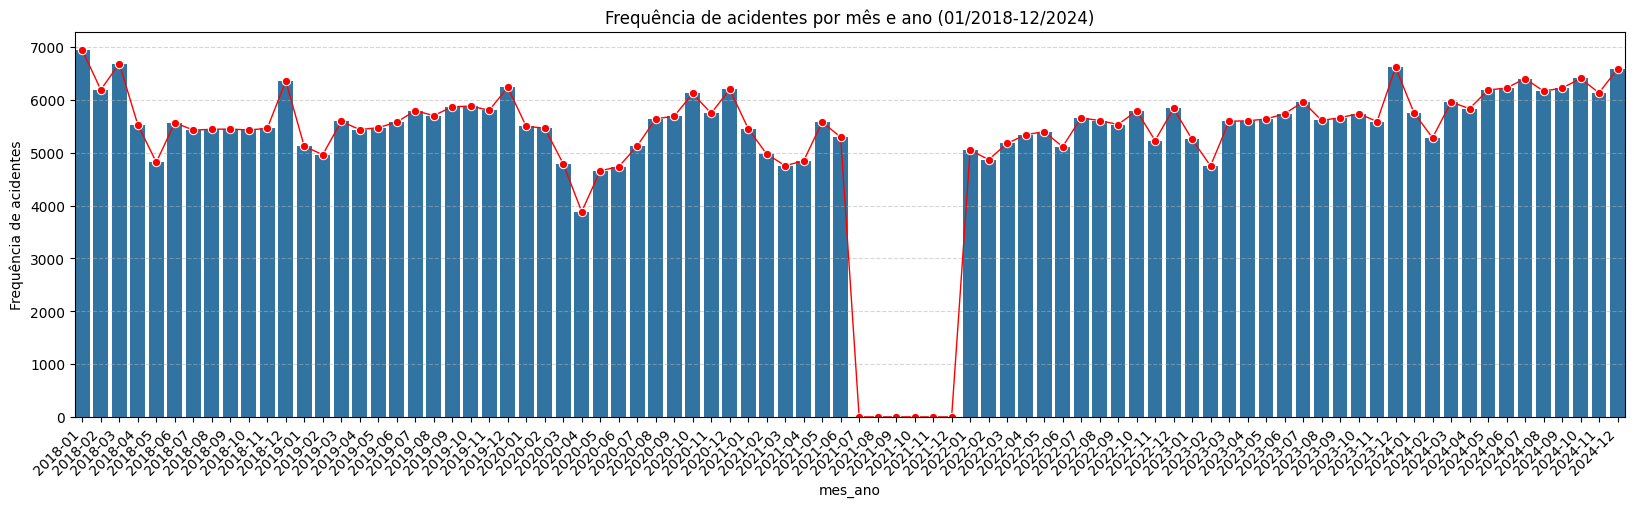

In [6]:
df_month_year = group_by_month_year()
df = pd.DataFrame({
    "mes_ano": df_month_year.index, "frequencia": df_month_year.values
})
draw_barplot(
    enable_lineplot=True,
    set_yscale=False,
    df=df,
    x="mes_ano",
    y="frequencia",
    title="Frequência de acidentes por mês e ano (01/2018-12/2024)"
)

#### Análise da distribuição dos acidentes por ano

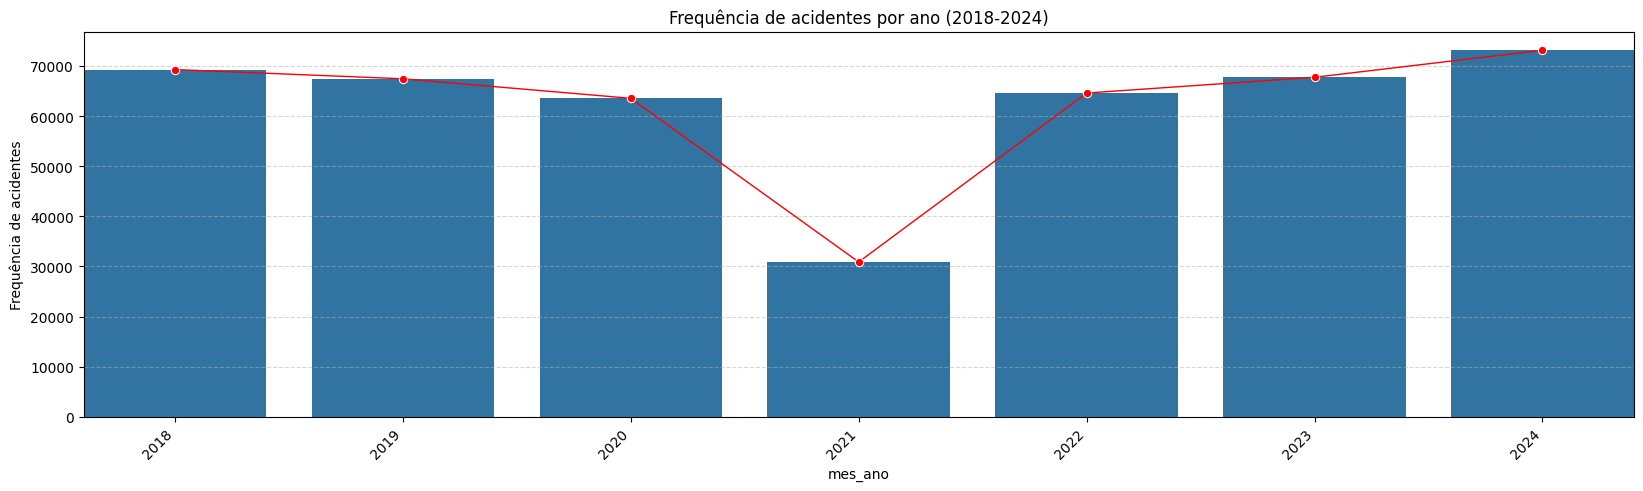

In [7]:
df_year = group_by_year()
df = pd.DataFrame({
    "mes_ano": df_year.index, "frequencia": df_year.values
})
draw_barplot(
    enable_lineplot=True,
    set_yscale=False,
    df=df,
    x=df["mes_ano"].astype(str),
    y="frequencia",
    title="Frequência de acidentes por ano (2018-2024)"
)

#### Análise da distribuição dos acidentes por mês

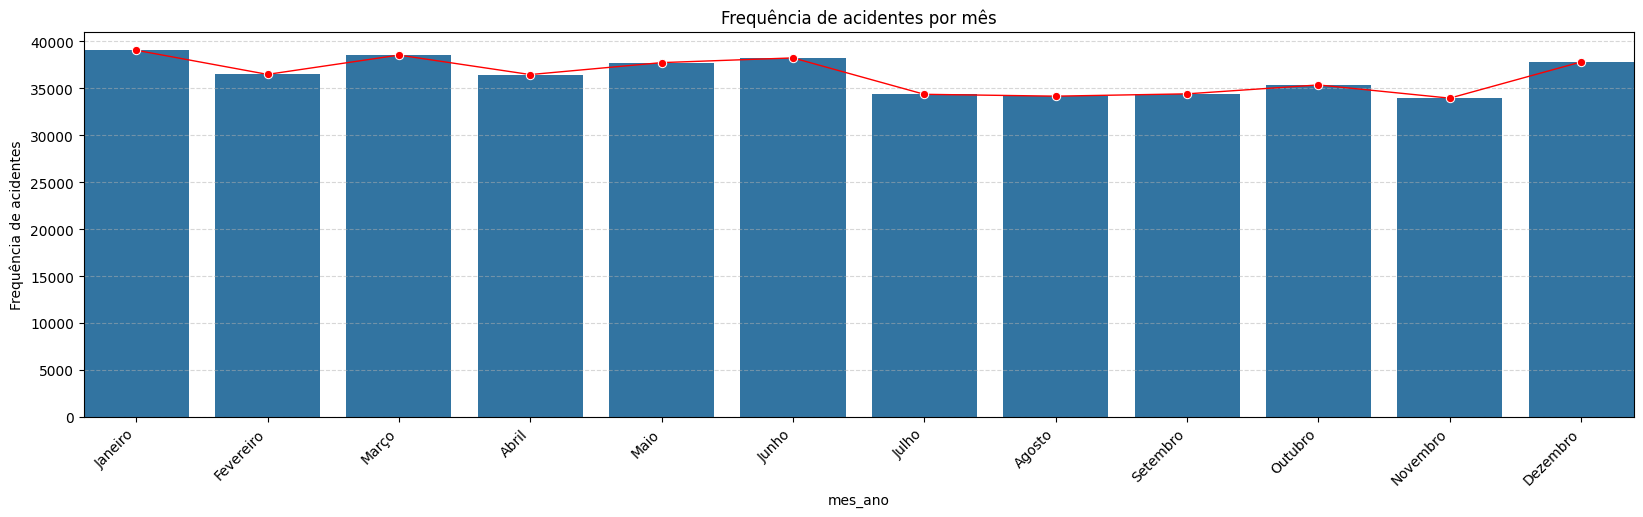

In [8]:
df_month = group_by_month()
df = pd.DataFrame({
    "mes_ano": df_month.index, "frequencia": df_month.values
})
draw_barplot(
    enable_lineplot=True,
    set_yscale=False,
    df=df,
    x="mes_ano",
    y="frequencia",
    title="Frequência de acidentes por mês"
)

#### Analisando os dados do ano de 2021, foi possível perceber que os meses de julho a dezembro não foram populados. Para não influenciar negativamente nas análises, preencherei esses dados considerando a média ou mediana dos demais anos

In [9]:
end_of_month = dict({7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31})


def fill_occurrences_dict(df, day, month, year):
    occurrences_dict = {}
    current_date = f'{year}-{month:02d}-{day:02d}'
    count = df_accidents[df == current_date].shape[0]
    occurrences_dict[current_date] = count
    return occurrences_dict


def create_lines_by_mean(day, month, mean):
    value = [pd.to_datetime(f'2021-{month:02d}-{day:02d}')] * mean
    return pd.DataFrame({
        'data_inversa': value, 'mes_ano': value,
    })


def fill_na(df):
    for col in df_accidents.columns:
        if col not in ('data_inversa', 'mes_ano'):
            df[col] = np.nan
    return df


for month in end_of_month:
    for day in range(1, end_of_month[month] + 1):
        for year in [2018, 2019, 2020, 2022, 2023, 2024]:
            occurrences = fill_occurrences_dict(
                df_accidents["data_inversa"], day, month, year)

        mean = int(np.mean(list(occurrences.values())))

        df = create_lines_by_mean(day, month, mean)
        df = fill_na(df)

        df_accidents = pd.concat(
            [df_accidents, df], ignore_index=True)

df_accidents["mes_ano"] = df_accidents["data_inversa"].dt.to_period("M")
df_accidents.to_csv(
    "analysis/datatran2018_2024_v2.csv", index=False)

#### Lendo a nova base de dados após o tratamento do ano de 2021

In [10]:
df_accidents = pd.read_csv(
    "analysis/datatran2018_2024_v2.csv",
    parse_dates=["data_inversa", "mes_ano"]
)
df_accidents.reset_index(drop=True, inplace=True)

/var/folders/z1/3syxl8gd5ks431s8c9n9mrs00000gn/T/ipykernel_15310/3160298662.py:1: DtypeWarning: Columns (2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_accidents = pd.read_csv(


#### Análise da distribuição dos acidentes por mês e ano (após tratamento de 2021)

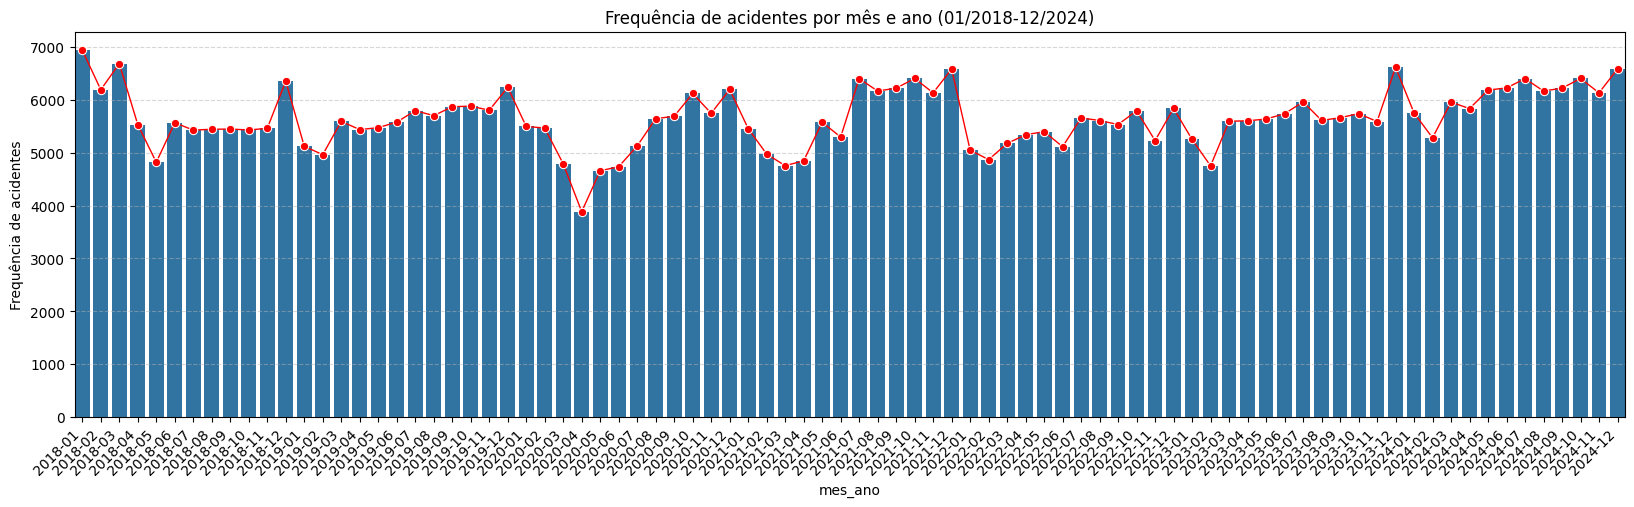

In [11]:
df_month_year = group_by_month_year()
df = pd.DataFrame({
    "mes_ano": df_month_year.index, "frequencia": df_month_year.values
})
draw_barplot(
    enable_lineplot=True,
    set_yscale=False,
    df=df,
    x="mes_ano",
    y="frequencia",
    title="Frequência de acidentes por mês e ano (01/2018-12/2024)"
)

#### Análise da distribuição dos acidentes por ano (após tratamento de 2021)

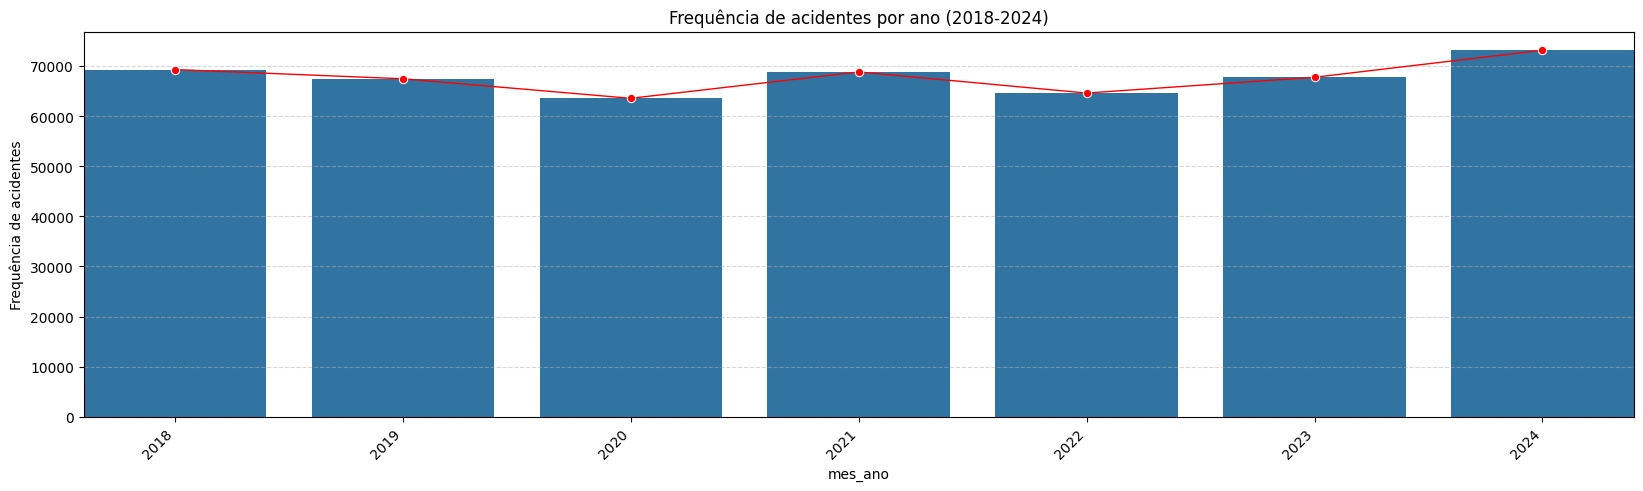

In [12]:
df_year = group_by_year()
df = pd.DataFrame({
    "mes_ano": df_year.index, "frequencia": df_year.values
})
draw_barplot(
    enable_lineplot=True,
    set_yscale=False,
    df=df,
    x=df["mes_ano"].astype(str),
    y="frequencia",
    title="Frequência de acidentes por ano (2018-2024)"
)

#### Análise da distribuição dos acidentes por mês (após tratamento de 2021)

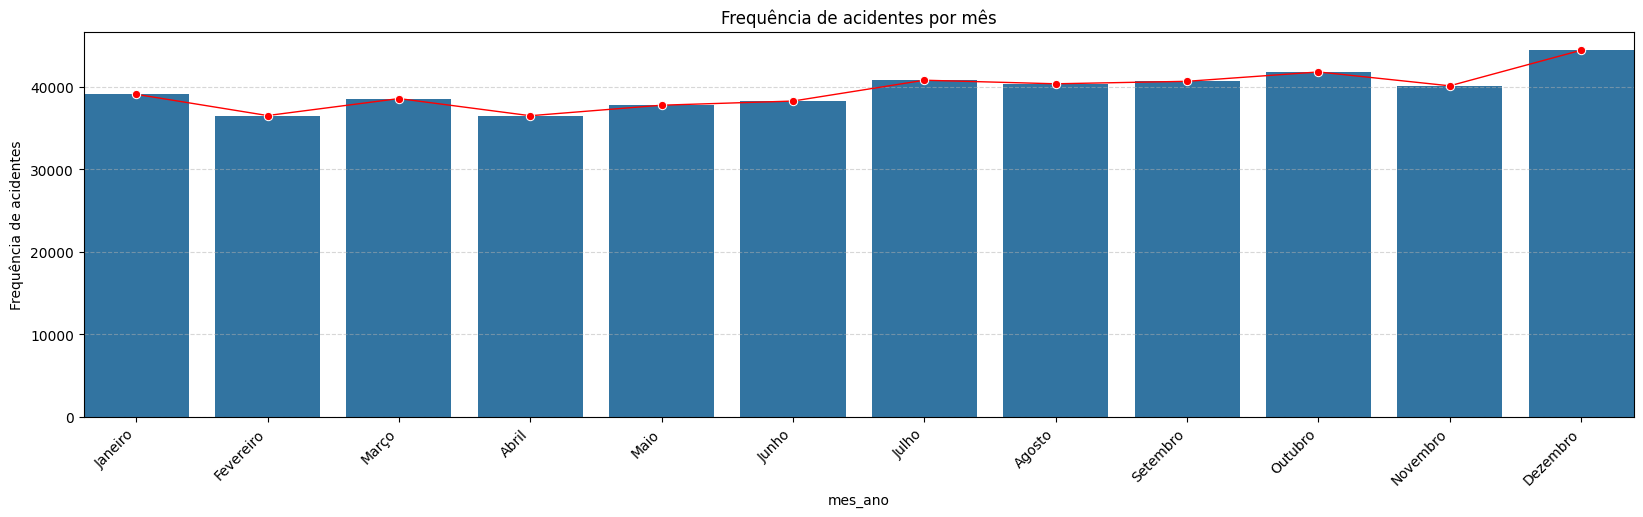

In [13]:
df_month = group_by_month()
df = pd.DataFrame({
    "mes_ano": df_month.index, "frequencia": df_month.values
})
draw_barplot(
    enable_lineplot=True,
    set_yscale=False,
    df=df,
    x="mes_ano",
    y="frequencia",
    title="Frequência de acidentes por mês"
)

#### Análise univariada da coluna tipo_data, agrupando por Feriado ou Dia útil

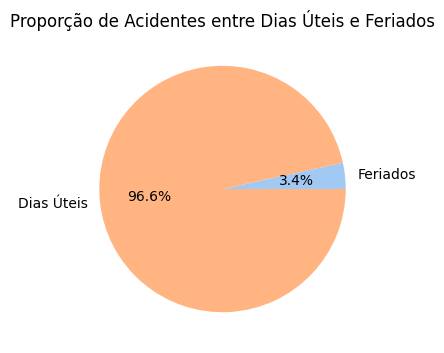

In [56]:
series = sort_by_values(df=df_accidents["tipo_data"]).reset_index()
series.columns = ["tipo_data", "frequencia"]

df = pd.DataFrame(
    {
        "categoria":
            ["Feriados", "Dias Úteis"],
        "frequencia": [
            series[series["tipo_data"] != "Dia útil"]["frequencia"].sum(),
            series[series["tipo_data"] == "Dia útil"]["frequencia"].sum()
        ]
    }
)

draw_pie(
    df=df["frequencia"],
    labels=df["categoria"],
    title="Proporção de Acidentes entre Dias Úteis e Feriados"
)

#### Analisando os feriados com mais ocorrências de acidentes

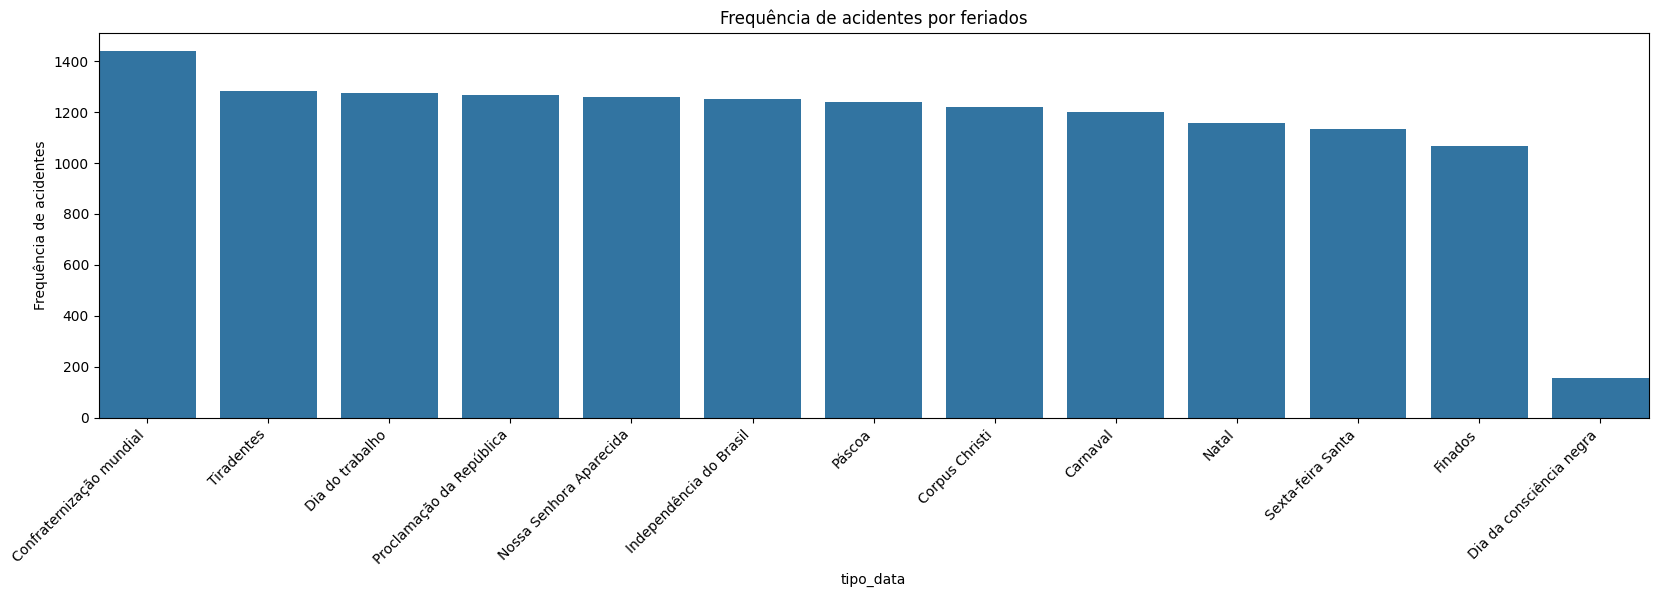

In [15]:
df_holidays = df_accidents[df_accidents["tipo_data"] != "Dia útil"]
df_holidays = df_holidays["tipo_data"].value_counts().reset_index()
df_holidays.columns = ["tipo_data", "frequencia"]

draw_barplot(
    enable_lineplot=False,
    set_yscale=False,
    df=df_holidays,
    x="tipo_data",
    y="frequencia",
    title="Frequência de acidentes por feriados"
)

#### Análise da distribuição de acidentes de acordo com o dia da semana

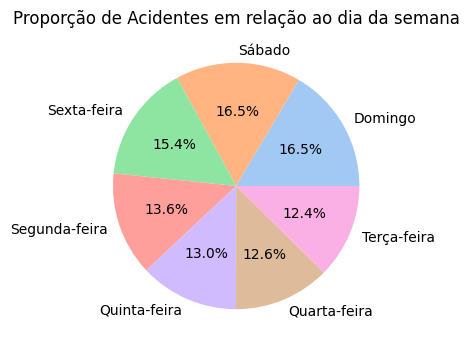

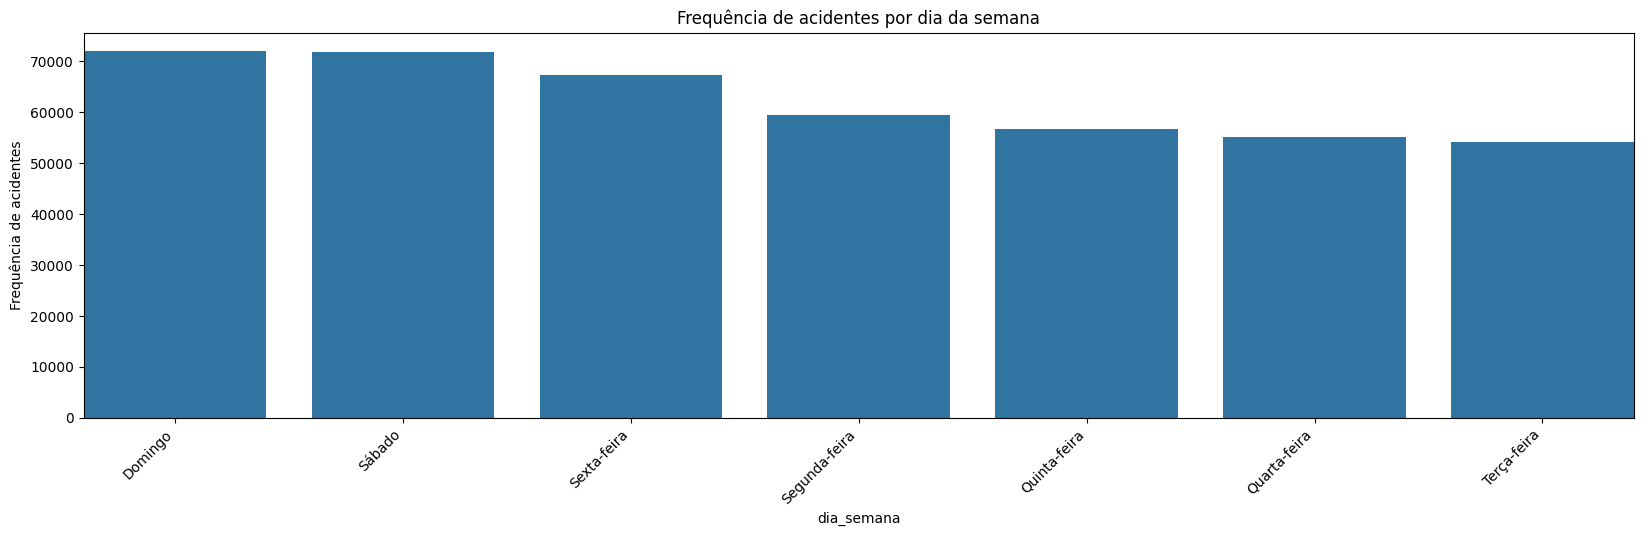

In [20]:
df = df_accidents["dia_semana"].value_counts().reset_index()
df.columns = ["dia_semana", "frequencia"]

draw_pie(
    df=df["frequencia"],
    labels=df["dia_semana"],
    title="Proporção de Acidentes em relação ao dia da semana"
)

draw_barplot(
    enable_lineplot=False,
    set_yscale=False,
    df=df,
    x="dia_semana",
    y="frequencia",
    title="Frequência de acidentes por dia da semana"
)


#### Análise da distribuição de acidentes por horário

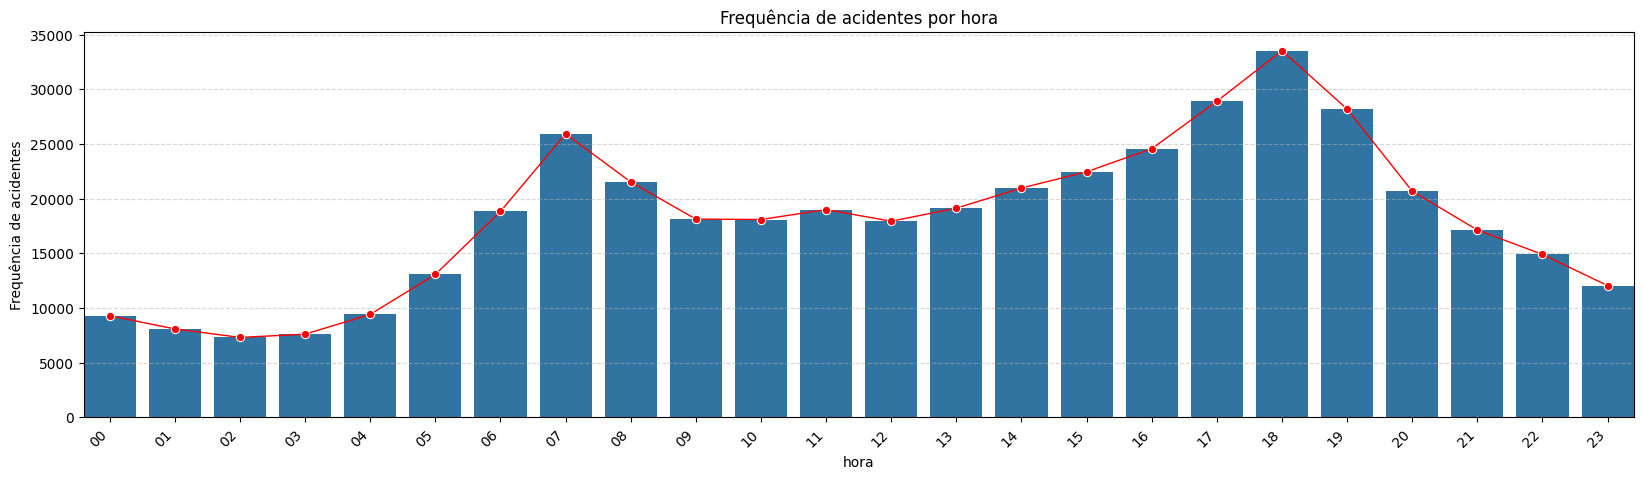

In [66]:
df = group_by_hour(df_accidents)
df = to_datetime(df)
df = sort_by_index(df).reset_index()
df.columns = ["hora", "frequencia"]

draw_barplot(
    enable_lineplot=True,
    set_yscale=False,
    df=df,
    x="hora",
    y="frequencia",
    title="Frequência de acidentes por hora"
)